In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pickle
from striprtf.striprtf import rtf_to_text
import string
from os import listdir
from datetime import datetime
from tqdm import tqdm
import cathay.re.SVO_final as SVO
import re
from cathay.config import ApplicationConfig
import boto3
from multiprocessing import Pool
import torch.multiprocessing as mp
import nltk
from transformers import *
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch import optim
import torch.nn.functional as F
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

Using TensorFlow backend.


In [2]:
torch.cuda.is_available()

True

### TWII Price
#### 2006/10/20前、2013/11/20之後的資料拔掉

#### N日內有漲/跌超過r%視為漲/跌

In [46]:
price = pd.read_csv('^TWII.csv')
price['Date'] = price['Date'].apply(lambda x:x.replace('-', ''))
price = price.dropna()

In [47]:
price['return1'] = price.shift(-1)['Adj Close'] / price['Adj Close']
price['return2'] = price.shift(-2)['Adj Close'] / price['Adj Close']
price['return3'] = price.shift(-3)['Adj Close'] / price['Adj Close']
# price['return4'] = price.shift(-4)['Adj Close'] / price['Adj Close']
# price['return5'] = price.shift(-5)['Adj Close'] / price['Adj Close']
# price['return6'] = price.shift(-6)['Adj Close'] / price['Adj Close']
# price['return7'] = price.shift(-7)['Adj Close'] / price['Adj Close']
# price['return8'] = price.shift(-8)['Adj Close'] / price['Adj Close']
# price['return9'] = price.shift(-9)['Adj Close'] / price['Adj Close']
# price['return10'] = price.shift(-10)['Adj Close'] / price['Adj Close']

price = price.dropna()
price['return'] = price.apply(lambda x:max([x['return1'], x['return2'], x['return3']]), axis=1)
# price['return'] = price.apply(lambda x:max([x['return1'], x['return2'], x['return3'], x['return4'], x['return5']]), axis=1)
# price['return'] = price.apply(lambda x:max([x['return1'], x['return2'], x['return3'], x['return4'], x['return5'], x['return6'], x['return7'], x['return8'], x['return9'], x['return10']]), axis=1)
price = price.reset_index(drop=True)

In [41]:
price.describe()

,Open,High,Low,Close,Adj Close,Volume,return1,return2,return3,return,label
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1.423000e+03,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000
mean,9704.390504,9742.047333,9661.098540,9702.309477,9702.295198,2.082229e+08,1.000265,1.000528,1.000784,1.005562,0.678145
std,933.613023,932.368228,936.323242,934.153842,934.165249,6.316822e+08,0.008096,0.011429,0.014056,0.010123,0.467352
min,7427.359863,7677.930176,7203.069824,7410.339844,7410.312012,7.990000e+05,0.936875,0.922854,0.923771,0.959776,0.000000
25%,8988.970215,9024.395019,8946.734863,8978.390137,8978.356933,1.816250e+06,0.996332,0.993939,0.992981,0.999467,0.000000
50%,9622.639648,9654.669922,9579.349609,9621.730469,9621.694336,2.135200e+06,1.000591,1.001448,1.001311,1.004952,1.000000
75%,10565.555176,10612.419922,10521.695312,10563.739746,10563.739746,2.548700e+06,1.004980,1.007783,1.009471,1.011188,1.000000
max,11645.730469,11668.200195,11604.679688,11656.400391,11656.400391,3.096593e+09,1.035801,1.044778,1.059533,1.059533,1.000000


In [5]:
price['label'] = 0
for i in price.index:
    for j in ['return1', 'return2', 'return3']:
        if price.loc[i, j] >= 1.007:
            price.loc[i, 'label'] = 1
            break
        elif price.loc[i, j] <= 0.993:
            price.loc[i, 'label'] = -1
            break
price = price[price['Date'] <= '20191130']
price = price[price['Date'] >= '20140201']
price = price.reset_index(drop=True)

In [6]:
a = Counter(price['label'])
a

Counter({1: 551, 0: 390, -1: 458})

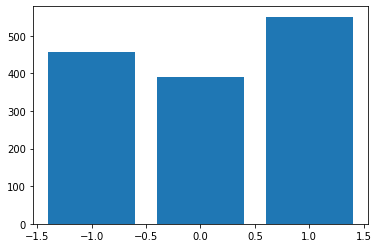

In [8]:
plt.bar([1, 0, -1], [a[1], a[0], a[-1]])
plt.show()

#### 第N日的Close有漲跌

In [2]:
# price = pd.read_csv('^TWII.csv')
# price['Date'] = price['Date'].apply(lambda x:x.replace('-', ''))
# price['return'] = price.shift(-3)['Adj Close'] / price['Adj Close']
# price = price.dropna()

In [48]:
price['label'] = 0
# 3日
price.loc[price[price['return'] > 1.001].index, 'label'] = 1
# 5日
# price.loc[price[price['return'] > 1.005].index, 'label'] = 1
# 10日
# price.loc[price[price['return'] > 1.01].index, 'label'] = 1
price = price[price['Date'] <= '20191130']
price = price[price['Date'] >= '20140201']
price = price.reset_index(drop=True)

In [49]:
from collections import Counter
a = Counter(price['label'])
a

Counter({1: 965, 0: 458})

#### Data split (日期切分) 

In [7]:
with open('Event_embedding(1channel_1).pkl', 'rb') as f:
    datas = pickle.load(f)
    
event = [(k, datas[k]) for k in sorted(datas.keys())]
dates = [x[0] for x in event]
event_embedding = [x[1] for x in event]

In [8]:
all_data = []
for i in tqdm(range(len(price))):
    data = {}
    if price.loc[i, 'Date'] in dates:
        data['date'] = dates.index(price.loc[i, 'Date'])
    tmp = int(price.loc[i, 'Date'])
    while str(tmp) not in dates:
        tmp -= 1
    data['date'] = dates.index(str(tmp))
    data['label'] = price.loc[i, 'label']
    all_data.append(data)

100%|██████████| 1423/1423 [00:00<00:00, 1813.71it/s]


In [9]:
# all_data = all_data[:-120]
test = all_data[-int(len(all_data)*0.1):]
tmp = all_data[:int(len(all_data)*0.9)+1]
valid = tmp[-int(len(tmp)*0.1):]
train = tmp[:int(len(tmp)*0.9)]
print('Train: ', len(train))
print('Valid:' , len(valid))
print('Test: ', len(test))

print('train: ', dates[train[0]['date']], dates[train[-1]['date']])
print('valid: ', dates[valid[0]['date']], dates[valid[-1]['date']])
print('test : ', dates[test[0]['date']], dates[test[-1]['date']])

print(len([x for x in train if x['label'] == 1])/len(train))
print(len([x for x in valid if x['label'] == 1])/len(valid))
print(len([x for x in test if x['label'] == 1])/len(test))

Train:  1152
Valid: 128
Test:  142
train:  20140205 20181017
valid:  20181019 20190506
test :  20190507 20191129
0.6762152777777778
0.734375
0.6408450704225352


In [50]:
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.65)
# rus = RandomOverSampler(random_state=42)
X, Y = rus.fit_resample([[x['date']] for x in train] + [[x['date']] for x in valid], [x['label'] for x in train]+[x['label'] for x in valid])
# X, Y = rus.fit_resample([[x['date']] for x in train], [x['label'] for x in train])
train = [dict({'date':X[i][0], 'label':Y[i]}) for i in range(len(X))]

In [51]:
print('Train: ', len(train))
print('Valid:' , len(valid))
print('Test: ', len(test))

print(len([x for x in train if x['label'] == 1])/len(train))
print(len([x for x in valid if x['label'] == 1])/len(valid))
print(len([x for x in test if x['label'] == 1])/len(test))

Train:  1017
Valid: 126
Test:  139
0.6057030481809242
0.7380952380952381
0.6546762589928058


## Model

In [10]:
class EventDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return dict(self.data[index])
    
    def collate_fn(self, datas):
        batch = {}
        
        batch['token'] = torch.tensor([list(range(x['date'] - 29, x['date'] + 1)) for x in datas])
#         batch['label'] = torch.tensor([self._label(x['label']) for x in datas])
        batch['label'] = torch.tensor([x['label'] for x in datas])
        
        return batch
    
    def _label(self, label):
        if label == -1:
            return 0
        elif label == 0:
            return 1
        else:
            return 2


In [13]:
train_set = EventDataset(train)
train_loader = DataLoader(train_set, collate_fn=train_set.collate_fn, batch_size=32, shuffle=True)
valid_set = EventDataset(valid)
valid_loader = DataLoader(valid_set, collate_fn=valid_set.collate_fn, batch_size=len(valid), shuffle=False)

In [11]:
class LSTMNet(nn.Module):
    def __init__(self, pretrained_embedding):
        super(LSTMNet, self).__init__()
        
        pretrained_embedding = torch.FloatTensor(pretrained_embedding)
        self.embedding = nn.Embedding(
            pretrained_embedding.size(0),
            pretrained_embedding.size(1))
        self.embedding.weight = torch.nn.Parameter(pretrained_embedding)
        self.embedding.weight.requires_grad = False
        
        bi = True
        self.lstm = nn.LSTM(pretrained_embedding.size(1), 800, 2, dropout=0.2, bidirectional=bi, batch_first=True)
        self.lstm.apply(self.init_normal)
        
        self.hidden2out = nn.Sequential(
            nn.AvgPool1d(5),
            nn.Flatten(),
            
            nn.BatchNorm1d(800 * (1+bi) * 6),
            nn.LeakyReLU(0.4),
            nn.Linear(800 * (1+bi) * 6, 400),
            
#             nn.BatchNorm1d(200),
#             nn.LeakyReLU(0.2),
#             nn.Linear(200, 400),
            
            nn.BatchNorm1d(400),
            nn.LeakyReLU(0.4),
            nn.Linear(400, 100),
            
            nn.BatchNorm1d(100),
            nn.LeakyReLU(0.4),
            nn.Linear(100, 2)
        )
        
        self.hidden2out.apply(self.init_normal)
    
    def forward(self, event):
        x = self.embedding(event)
        out, (_, _) = self.lstm(x)
        out = out.transpose(1, 2)
        
        y = self.hidden2out(out)
        return y
    
    def init_normal(self, m):
        if type(m) == nn.Linear:
            nn.init.orthogonal_(m.weight)
#             nn.init.xavier_normal_(m.weight.data)
#             nn.init.normal_(m.bias.data)
        if type(m) == nn.LSTM:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
#                     nn.init.xavier_normal_(param.data)
                    nn.init.orthogonal_(param.data)
                elif 'weight_hh' in name:
#                     nn.init.xavier_normal_(param.data)
                    nn.init.orthogonal_(param.data)
                elif 'bias' in name:
                    param.data.fill_(0)
        if isinstance(m, nn.BatchNorm1d):
            nn.init.normal_(m.weight.data)
#             nn.init.constant_(m.bias.data, 0)

In [28]:
EPOCH = 50
model = LSTMNet(event_embedding)
use_gpu = torch.cuda.is_available()
if use_gpu:
    model.cuda()
    
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss()

acc_history = []
loss_history = []
valid_history = []
valid_loss = []

In [29]:
for epoch in range(EPOCH):
    model.train()
    train_loss = []
    train_acc = []
    for data in train_loader:
        if use_gpu:
            event = data['token'].cuda()
            labels = data['label'].cuda()
            
        optimizer.zero_grad()
        output = model(event)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        
        predict = output.max(1)[1]
#         predict = torch.tensor([1 if x >=0.5 else 0 for x in output]).cuda()
        acc = np.mean((labels == predict).cpu().numpy())
        train_acc.append(acc)
        train_loss.append(loss.item())
        
    print("Epoch: {}, train Loss: {:.4f}, train accuracy: {:.4f}".format(epoch + 1, np.mean(train_loss), np.mean(train_acc)))
    acc_history.append(np.mean(train_acc))
    loss_history.append(np.mean(train_loss))
    
    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            if use_gpu:
                event = data['token'].cuda()
                labels = data['label'].cuda()

            output = model(event)
            loss = loss_fn(output, labels)
            predict = output.max(1)[1]
#             predict = torch.tensor([1 if x >=0.5 else 0 for x in output]).cuda()
            acc = np.mean((labels == predict).cpu().numpy())
        print("Epoch: {}, valid loss: {:.4f}, valid accuracy: {:.4f}".format(epoch + 1, loss, acc))
        valid_history.append(acc)
        valid_loss.append(loss)
        
    if acc >= 0.64 and acc < 0.70:
        checkpoint_path = 'LSTM(3day_10day)_{}({:.4f}).pth'.format(epoch+1, acc) 
        torch.save(model.state_dict(), checkpoint_path)
        print('model saved to %s' % checkpoint_path)

Epoch: 1, train Loss: 0.8510, train accuracy: 0.5165
Epoch: 1, valid loss: 0.7786, valid accuracy: 0.2891
Epoch: 2, train Loss: 0.7390, train accuracy: 0.5946
Epoch: 2, valid loss: 0.7090, valid accuracy: 0.5078
Epoch: 3, train Loss: 0.6874, train accuracy: 0.6163
Epoch: 3, valid loss: 0.7913, valid accuracy: 0.3828
Epoch: 4, train Loss: 0.6128, train accuracy: 0.6736
Epoch: 4, valid loss: 0.8007, valid accuracy: 0.4766
Epoch: 5, train Loss: 0.6098, train accuracy: 0.6780
Epoch: 5, valid loss: 0.9590, valid accuracy: 0.3672
Epoch: 6, train Loss: 0.5145, train accuracy: 0.7465
Epoch: 6, valid loss: 0.8401, valid accuracy: 0.4688
Epoch: 7, train Loss: 0.4903, train accuracy: 0.7569
Epoch: 7, valid loss: 0.9361, valid accuracy: 0.4219
Epoch: 8, train Loss: 0.5079, train accuracy: 0.7526
Epoch: 8, valid loss: 0.8080, valid accuracy: 0.5000
Epoch: 9, train Loss: 0.4541, train accuracy: 0.7908
Epoch: 9, valid loss: 0.9913, valid accuracy: 0.4219
Epoch: 10, train Loss: 0.4485, train accuracy:

Epoch: 36, valid accuracy: 0.6719


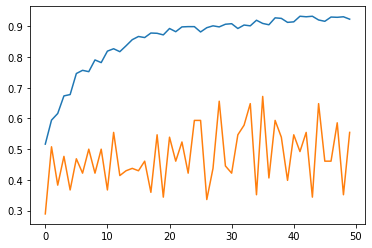

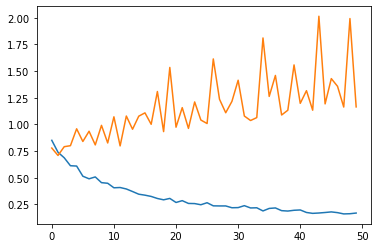

In [30]:
# 10日 valid
print('Epoch: {}, valid accuracy: {:.4f}'.format(valid_history.index(max(valid_history))+1, max(valid_history)))

import matplotlib.pyplot as plt
plt.plot(list(range(len(acc_history))), acc_history, list(range(len(valid_history))), valid_history)
plt.show()


plt.plot(list(range(len(loss_history))), loss_history, list(range(len(valid_loss))), valid_loss)
plt.show()

Epoch: 35, valid accuracy: 0.6719


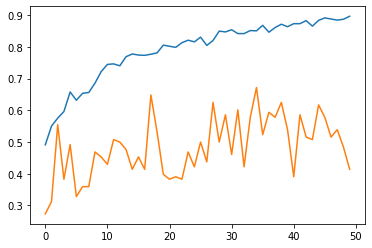

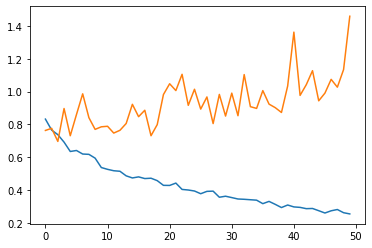

In [38]:
# 5日 valid
print('Epoch: {}, valid accuracy: {:.4f}'.format(valid_history.index(max(valid_history))+1, max(valid_history)))

import matplotlib.pyplot as plt
plt.plot(list(range(len(acc_history))), acc_history, list(range(len(valid_history))), valid_history)
plt.show()


plt.plot(list(range(len(loss_history))), loss_history, list(range(len(valid_loss))), valid_loss)
plt.show()

Epoch: 8, valid accuracy: 0.6835


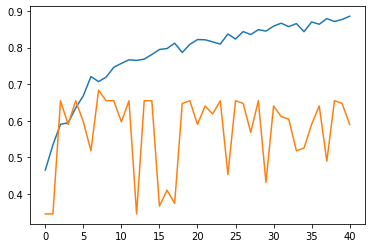

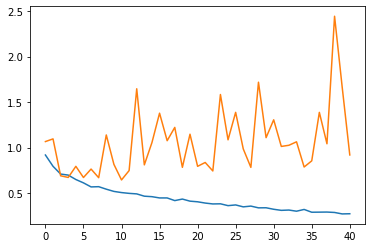

In [23]:
print('Epoch: {}, valid accuracy: {:.4f}'.format(valid_history.index(max(valid_history))+1, max(valid_history)))

import matplotlib.pyplot as plt
plt.plot(list(range(len(acc_history))), acc_history, list(range(len(valid_history))), valid_history)
plt.show()


plt.plot(list(range(len(loss_history))), loss_history, list(range(len(valid_loss))), valid_loss)
plt.show()

Epoch: 35, valid accuracy: 0.7016


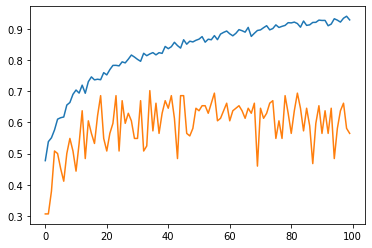

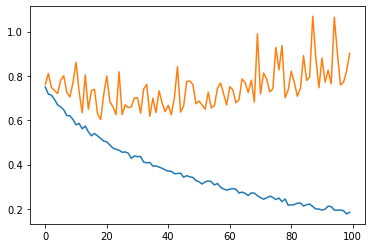

In [14]:
# II validation
print('Epoch: {}, valid accuracy: {:.4f}'.format(valid_history.index(max(valid_history))+1, max(valid_history)))

import matplotlib.pyplot as plt
plt.plot(list(range(len(acc_history))), acc_history, list(range(len(valid_history))), valid_history)
plt.show()


plt.plot(list(range(len(loss_history))), loss_history, list(range(len(valid_loss))), valid_loss)
plt.show()

In [25]:
print('Epoch: {}, valid accuracy: {:.4f}'.format(valid_history.index(max(valid_history))+1, max(valid_history)))

Epoch: 38, valid accuracy: 0.7063


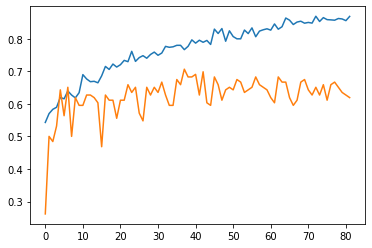

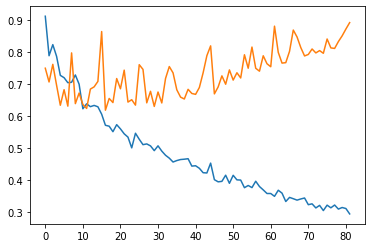

In [26]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(acc_history))), acc_history, list(range(len(valid_history))), valid_history)
plt.show()


plt.plot(list(range(len(loss_history))), loss_history, list(range(len(valid_loss))), valid_loss)
plt.show()

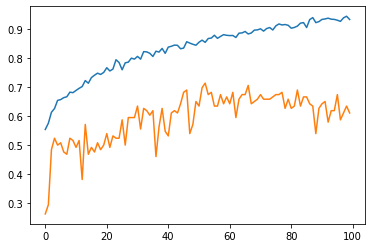

In [15]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(acc_history))), acc_history, list(range(len(valid_history))), valid_history)
plt.show()

# Testing

In [159]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
valid_set = EventDataset(valid)
valid_loader = DataLoader(valid_set, collate_fn=valid_set.collate_fn, batch_size=len(valid), shuffle=False)

In [160]:
model = LSTMNet(event_embedding)
model.load_state_dict(torch.load('LSTM(3day)_38(0.7266).pth'))
use_gpu = torch.cuda.is_available()
if use_gpu:
    model.cuda()


In [161]:
model.eval()
with torch.no_grad():
    for data in valid_loader:
        if use_gpu:
            event = data['token'].cuda()
            labels = data['label'].cuda()

        output = model(event)
        predict = output.max(1)[1]
        acc = accuracy_score(data['label'], predict.cpu())
        mcc = matthews_corrcoef(data['label'], predict.cpu())
        f1 = f1_score(data['label'], predict.cpu(), average='weighted')
        pre = precision_score(labels.cpu(), predict.cpu(), average='weighted')
        recall = recall_score(labels.cpu(), predict.cpu(), average='weighted')

In [162]:
print('acc: ', acc)
print('mcc: ', mcc)
print('F1: ', f1)
print('precision', pre)
print('recall', recall)

acc:  0.7265625
mcc:  0.22532655681035513
F1:  0.7077354976637575
precision 0.7005499482401656
recall 0.7265625


In [30]:
predict

tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 0, 0], device='cuda:0')

In [31]:
data['label']

tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 0])

# Bull / Bear market

In [176]:
price = pd.read_csv('^TWII.csv')
price['Date'] = price['Date'].apply(lambda x:x.replace('-', ''))
price = price[price['Date']<'20140101']
price = price.dropna()

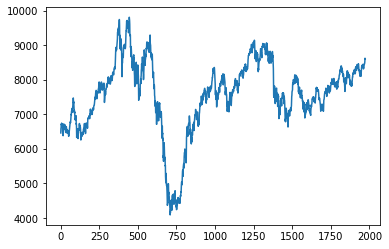

In [64]:
plt.plot(range(len(price)), list(price['Adj Close']))

1.3356661077661305


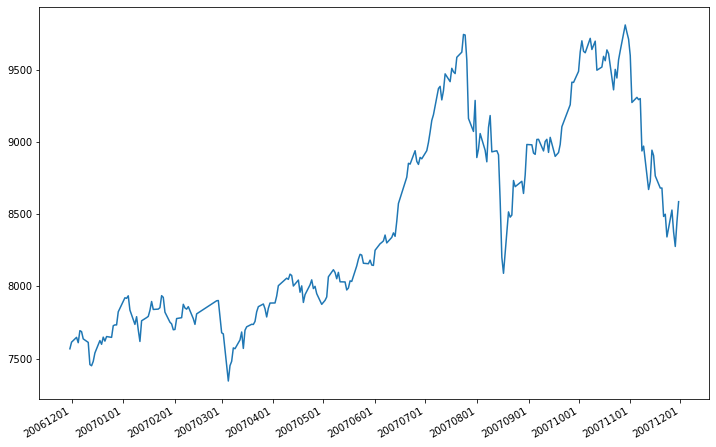

In [168]:
# Bull Market 1 
price = price[price['Date']<='20071130']
price = price[price['Date']>='20061130']

fig = plt.figure(figsize=(12, 8))

days = [datetime.strptime(x, '%Y%m%d') for x in list(price['Date'])]

ax1=fig.add_subplot(1,1,1)

ax1.plot(days, list(price['Adj Close']))
plt.gcf().autofmt_xdate()

alldays =  mdates.MonthLocator()
ax1.xaxis.set_major_locator(alldays)        
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))

print(max(price['Adj Close'])/min(price['Adj Close']))

1.9299701042552093


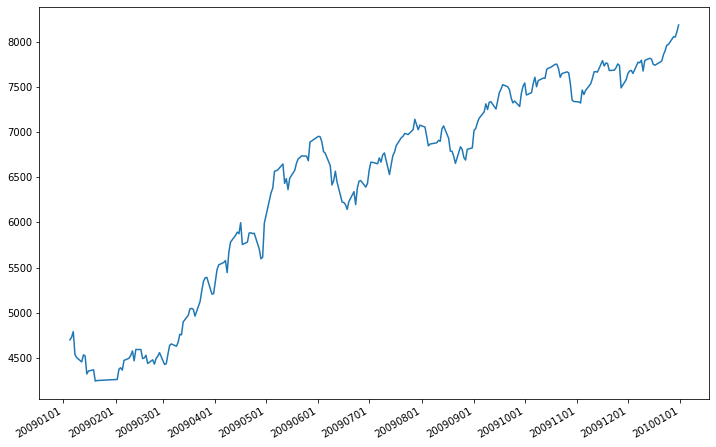

In [170]:
# Bull Market 2
price = price[price['Date']>='20090101']
price = price[price['Date']<='20100101']
fig = plt.figure(figsize=(12, 8))

days = [datetime.strptime(x, '%Y%m%d') for x in list(price['Date'])]

ax1=fig.add_subplot(1,1,1)

ax1.plot(days, list(price['Adj Close']))
plt.gcf().autofmt_xdate()

alldays =  mdates.MonthLocator()
ax1.xaxis.set_major_locator(alldays)        
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))

print(max(price['Adj Close'])/min(price['Adj Close']))

0.44000446511228836


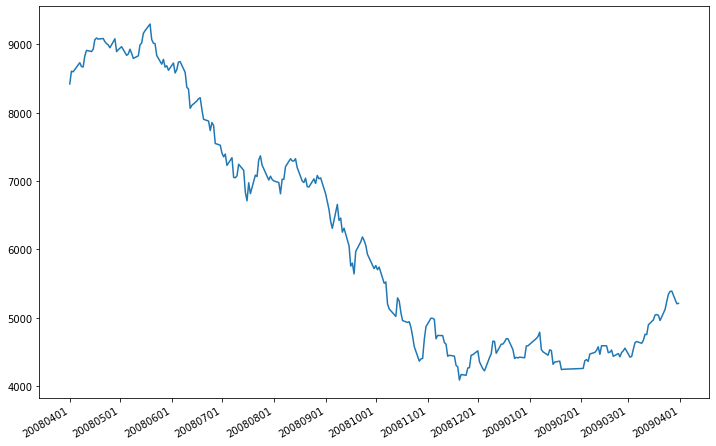

In [177]:
# Bear Market 2
price = price[price['Date']<='20090401']
price = price[price['Date']>='20080401']
fig = plt.figure(figsize=(12, 8))

days = [datetime.strptime(x, '%Y%m%d') for x in list(price['Date'])]

ax1=fig.add_subplot(1,1,1)

ax1.plot(days, list(price['Adj Close']))
plt.gcf().autofmt_xdate()

alldays =  mdates.MonthLocator()
ax1.xaxis.set_major_locator(alldays)        
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))

print(min(price['Adj Close'])/max(price['Adj Close']))

0.8399956785812924


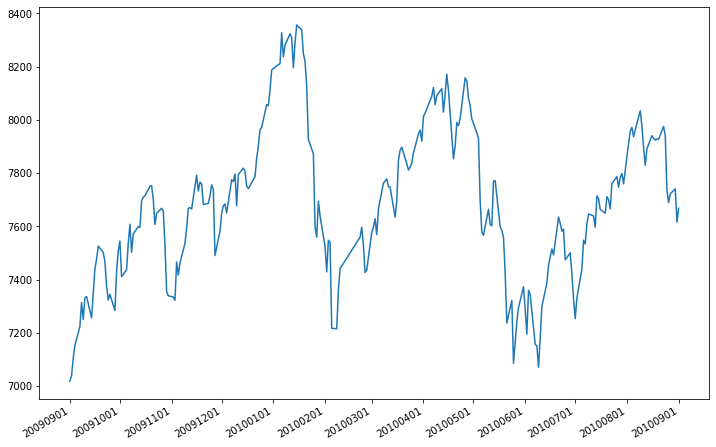

In [175]:
# Bear Market 1
price = price[price['Date']<='20100901']
price = price[price['Date']>='20090901']
fig = plt.figure(figsize=(12, 8))

days = [datetime.strptime(x, '%Y%m%d') for x in list(price['Date'])]

ax1=fig.add_subplot(1,1,1)

ax1.plot(days, list(price['Adj Close']))
plt.gcf().autofmt_xdate()

alldays =  mdates.MonthLocator()
ax1.xaxis.set_major_locator(alldays)        
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))

print(min(price['Adj Close'])/max(price['Adj Close']))

In [140]:
price['return1'] = price.shift(-1)['Adj Close'] / price['Adj Close']
price['return2'] = price.shift(-2)['Adj Close'] / price['Adj Close']
price['return3'] = price.shift(-3)['Adj Close'] / price['Adj Close']
# price['return4'] = price.shift(-3)['Adj Close'] / price['Adj Close']
# price['return5'] = price.shift(-3)['Adj Close'] / price['Adj Close']

price = price.dropna()
price['return'] = price.apply(lambda x:max([x['return1'], x['return2'], x['return3']]), axis=1)
# price['down'] = price.apply(lambda x:min([x['return1'], x['return2'], x['return3']]), axis=1)
price = price.reset_index(drop=True)

price['label'] = 0
price.loc[price[price['return'] > 1.001].index, 'label'] = 1
price = price.reset_index(drop=True)

In [133]:
from collections import Counter
a = Counter(price['label'])
a

Counter({1: 153, 0: 91})

In [110]:
# Event
with open('Event_embedding(1channel_1).pkl', 'rb') as f:
    datas = pickle.load(f)
    
event = [(k, datas[k]) for k in sorted(datas.keys())]
dates = [x[0] for x in event]
event_embedding = [x[1] for x in event]

all_data = []
for i in tqdm(range(len(price))):
    data = {}
    if price.loc[i, 'Date'] in dates:
        data['date'] = dates.index(price.loc[i, 'Date'])
    tmp = int(price.loc[i, 'Date'])
    while str(tmp) not in dates:
        tmp -= 1
    data['date'] = dates.index(str(tmp))
    data['label'] = price.loc[i, 'label']
    all_data.append(data)

100%|██████████| 249/249 [00:00<00:00, 5718.91it/s]


In [141]:
# No event
with open('news_embedding_baseline_2006.pkl', 'rb') as f:
    train_vector = pickle.load(f)
    
datas = dict(zip([x['date'] for x in train_vector], [x['title'] for x in train_vector]))
event = [(k, datas[k]) for k in sorted(datas.keys())]
dates = [x[0] for x in event][:2113]
event_embedding = [np.array(x[1].cpu()) for x in event][:2113]

all_data = []
for i in tqdm(range(len(price))):
    data = {}
    if price.loc[i, 'Date'] in dates:
        data['date'] = dates.index(price.loc[i, 'Date'])
    tmp = int(price.loc[i, 'Date'])
    while str(tmp) not in dates:
        tmp -= 1
    data['date'] = dates.index(str(tmp))
    data['label'] = price.loc[i, 'label']
    all_data.append(data)

100%|██████████| 249/249 [00:00<00:00, 5425.58it/s]


In [142]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
valid_set = EventDataset(all_data)
valid_loader = DataLoader(valid_set, collate_fn=valid_set.collate_fn, batch_size=len(all_data), shuffle=False)

In [143]:
model = LSTMNet(event_embedding)
# model.load_state_dict(torch.load('LSTM(3day_test)_26(0.6901).pth'))
model.load_state_dict(torch.load('LSTM_baseline(3day_test)_2(0.6620).pth'))
use_gpu = torch.cuda.is_available()
if use_gpu:
    model.cuda()

model.eval()
with torch.no_grad():
    for data in valid_loader:
        if use_gpu:
            event = data['token'].cuda()
            labels = data['label'].cuda()

        output = model(event)
        predict = output.max(1)[1]
        acc = accuracy_score(data['label'], predict.cpu())
        mcc = matthews_corrcoef(data['label'], predict.cpu())
        f1 = f1_score(data['label'], predict.cpu(), average='weighted')
        pre = precision_score(labels.cpu(), predict.cpu(), average='weighted')
        recall = recall_score(labels.cpu(), predict.cpu(), average='weighted')

In [89]:
# Test Bull Market 1 on valid model
print('acc: ', acc)
print('mcc: ', mcc)
print('F1: ', f1)
print('precision', pre)
print('recall', recall)

acc:  0.7095435684647303
mcc:  0.08224699949464384
F1:  0.6413429526609533
precision 0.6430750723525925
recall 0.7095435684647303


In [121]:
# Test Bull Market 1 on baseline model
print('acc: ', acc)
print('mcc: ', mcc)
print('F1: ', f1)
print('precision', pre)
print('recall', recall)

acc:  0.6390041493775933
mcc:  -0.12622816085022184
F1:  0.5784539981329693
precision 0.5391511219649789
recall 0.6390041493775933


In [97]:
# Test Bull Market 2 on valid model
print('acc: ', acc)
print('mcc: ', mcc)
print('F1: ', f1)
print('precision', pre)
print('recall', recall)

acc:  0.7254098360655737
mcc:  -0.02886601674186042
F1:  0.6618629920535499
precision 0.6286804357204487
recall 0.7254098360655737


In [129]:
# Test Bull Market 2 on baseline model
print('acc: ', acc)
print('mcc: ', mcc)
print('F1: ', f1)
print('precision', pre)
print('recall', recall)

acc:  0.6598360655737705
mcc:  0.032320999967352666
F1:  0.6565926930539706
precision 0.6535111686319623
recall 0.6598360655737705


In [105]:
# Test Bear Market 2 on valid model
print('acc: ', acc)
print('mcc: ', mcc)
print('F1: ', f1)
print('precision', pre)
print('recall', recall)

acc:  0.6352459016393442
mcc:  0.10125939924208978
F1:  0.5381686141905292
precision 0.6138809693513898
recall 0.6352459016393442


In [137]:
# Test Bear Market 2 on baseline model
print('acc: ', acc)
print('mcc: ', mcc)
print('F1: ', f1)
print('precision', pre)
print('recall', recall)

acc:  0.5655737704918032
mcc:  -0.021270083409733673
F1:  0.5294983203494634
precision 0.5215048390884427
recall 0.5655737704918032


In [113]:
# Test Bear Market 1 on valid model
print('acc: ', acc)
print('mcc: ', mcc)
print('F1: ', f1)
print('precision', pre)
print('recall', recall)

acc:  0.6666666666666666
mcc:  -0.01398221544574403
F1:  0.5982847938705325
precision 0.5781604592177281
recall 0.6666666666666666


In [144]:
# Test Bear Market 1 on baseline model
print('acc: ', acc)
print('mcc: ', mcc)
print('F1: ', f1)
print('precision', pre)
print('recall', recall)

acc:  0.6385542168674698
mcc:  -0.0688113286164344
F1:  0.5806756437514765
precision 0.5522226838388035
recall 0.6385542168674698


# Market Simulation

In [24]:
print('valid: ', dates[valid[0]['date']], dates[valid[-1]['date']])
print('test: ', dates[test[0]['date']], dates[test[-1]['date']])

valid:  20181019 20190506
test:  20190507 20191129


In [163]:
date = []
for i in valid:
    date.append(dates[i['date']])

In [164]:
def buy(buy_price, money):
    hold = money / buy_price
#     print(money, buy_price)
#     print(hold)
    money = 0
    return hold, money

def sold(sold_price, hold):
    money = hold * sold_price
    hold = 0
    return hold, money

In [165]:
money = 10000.0
hold = 0
count = 0
fee = 0
buy_time = []
sell_time = []
for i in range(len(date)):
    Adj = price[price['Date']==date[i]]['Adj Close'].values[0]
    if hold == 0:
        if predict[i] == 1:
            hold, money = buy(Adj, money)
            buy_time.append(i)
            count = 3
            buy_price = Adj
            fee = hold * buy_price * 0.001425
            
    else:
        count -= 1
        if count != 0 and (Adj / buy_price) > 1.001:
            
            if predict[i] == 1:
#                 hold, money = buy(Adj, money)
                count = 3
#                 buy_price = Adj
            else:     
                fee += hold * Adj * 0.001425
                hold, money = sold(hold, Adj)
                sell_time.append(i)
                count = 0
                money -= fee
#                 print(fee)
                fee = 0
                
        elif count == 0 and hold != 0:
            if predict[i] == 1:
                count = 3
            else:
                fee += hold * Adj * 0.001425
                hold, money = sold(hold, Adj)
                sell_time.append(i)
                money -= fee
#                 print(fee)
                fee = 0               
            
            
    print('Money: {:.4f}, hold: {:.4f}'.format(money, hold))
    
if hold != 0:
    fee += hold * Adj * 0.001425
    hold, money = sold(hold, Adj)
    sell_time.append(i)
    money -= fee
    fee = 0
        
print('Return: ', money/10000) 

Money: 10000.0000, hold: 0.0000
Money: 10000.0000, hold: 0.0000
Money: 10000.0000, hold: 0.0000
Money: 10000.0000, hold: 0.0000
Money: 10000.0000, hold: 0.0000
Money: 10000.0000, hold: 0.0000
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0508
Money: 0.0000, hold: 1.0

In [111]:
import matplotlib.dates as mdates
from datetime import datetime

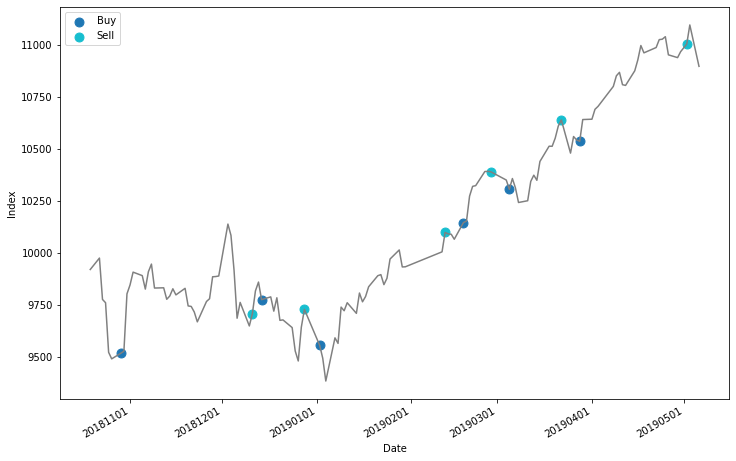

1.1826579541873083


In [166]:
# Valid
tmp = pd.read_csv('^TWII.csv')
tmp['Date'] = tmp['Date'].apply(lambda x:x.replace('-', ''))
tmp = price[price['Date']>'20140101']
tmp = tmp.dropna()

tmp = tmp[tmp['Date']<='20190506']
tmp = tmp[tmp['Date']>='20181019']

fig = plt.figure(figsize=(12, 8))

days = [datetime.strptime(x, '%Y%m%d') for x in list(tmp['Date'])]

ax1=fig.add_subplot(1,1,1)

ax1.plot(days, list(tmp['Adj Close']), c='gray')
plt.gcf().autofmt_xdate()

alldays =  mdates.MonthLocator()
ax1.xaxis.set_major_locator(alldays)        
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d')) 


ax1.scatter([days[x] for x in buy_time], [tmp.iloc[x]['Adj Close'] for x in buy_time], s=80, c = 'tab:blue', label='Buy')
ax1.scatter([days[x] for x in sell_time], [tmp.iloc[x]['Adj Close'] for x in sell_time], s=80, c = 'tab:cyan', label='Sell')
plt.xlabel('Date')
plt.ylabel('Index')

plt.legend()
plt.show()

print(max(tmp['Adj Close'])/min(tmp['Adj Close']))

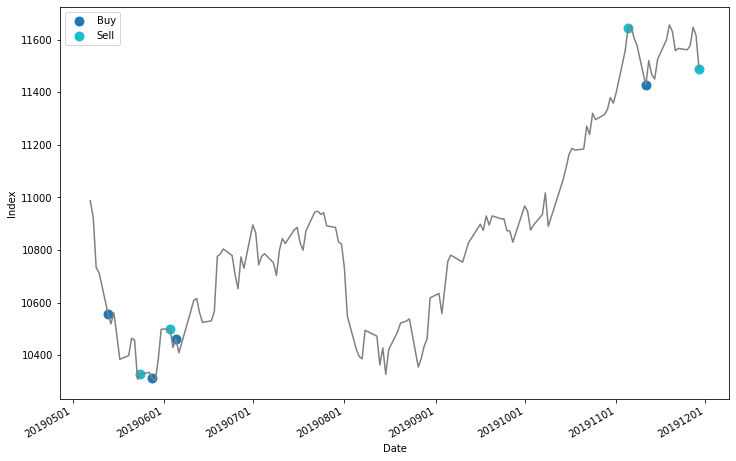

1.131493788656154


In [158]:
# Test
tmp = pd.read_csv('^TWII.csv')
tmp['Date'] = tmp['Date'].apply(lambda x:x.replace('-', ''))
tmp = price[price['Date']>'20140101']
tmp = tmp.dropna()

tmp = tmp[tmp['Date']<='20191129']
tmp = tmp[tmp['Date']>='20190507']

fig = plt.figure(figsize=(12, 8))

days = [datetime.strptime(x, '%Y%m%d') for x in list(tmp['Date'])]

ax1=fig.add_subplot(1,1,1)

ax1.plot(days, list(tmp['Adj Close']), c='gray')
plt.gcf().autofmt_xdate()

alldays =  mdates.MonthLocator()
ax1.xaxis.set_major_locator(alldays)        
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d')) 


ax1.scatter([days[x] for x in buy_time], [tmp.iloc[x]['Adj Close'] for x in buy_time], s=80, c = 'tab:blue', label='Buy')
ax1.scatter([days[x] for x in sell_time], [tmp.iloc[x]['Adj Close'] for x in sell_time], s=80, c = 'tab:cyan', label='Sell')
plt.xlabel('Date')
plt.ylabel('Index')

plt.legend()
plt.show()

print(max(tmp['Adj Close'])/min(tmp['Adj Close']))

In [77]:
buy_time

[6, 40, 51, 77, 86, 103]

In [78]:
sell_time

[37, 50, 73, 84, 99, 125]